In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ..

/


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import  plot_model ,Sequence
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp
from PIL import Image
import os
from glob import glob
from random import choice,sample
from matplotlib import pyplot as plt
import cv2

In [ ]:
path = '/content/drive/MyDrive/train_frame/Dataset1/Video/'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame/Dataset1/pix_train/{}'.format(f))

In [ ]:
path = '/content/drive/MyDrive/train_frame/Dataset1/Left_Instrument_Segmentation/'
for f in os.listdir(path):
    img = Image.open(os.path.join(path,f))
    img = img.convert('RGB')
    r,g,b = img.split()
    r = r.point(lambda i:i*32)
    out = Image.merge('RGB',(r,g,b))
    out.save('/content/drive/MyDrive/train_frame/Dataset1/pix_val/{}'.format(f))

In [ ]:
train_img_dir = '/content/drive/MyDrive/train_frame/Dataset1/Video/'
train_mask_dir = '/content/drive/MyDrive/train_frame/Dataset1/Left_Instrument_Segmentation/'
train_imgs = os.listdir(train_img_dir)
train_masks = os.listdir(train_mask_dir)
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])
print(len(train_imgs))
print(len(train_masks))

1107
1107


In [ ]:
print(train_imgs[:])
print(train_masks[:])

['0.png', '1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '1073.p

In [ ]:
from sklearn.model_selection import train_test_split
val_img_dir =  train_img_dir
val_mask_dir = train_mask_dir
train_imgs,val_imgs,train_masks,val_masks =  train_test_split(train_imgs, train_masks, test_size=0.13, random_state=42)
print(len(train_masks))
print(len(val_masks))

963
144


In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [k for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [ ]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

26

<ipython-input-33-a12701893d80>:57: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-33-a12701893d80>:58: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


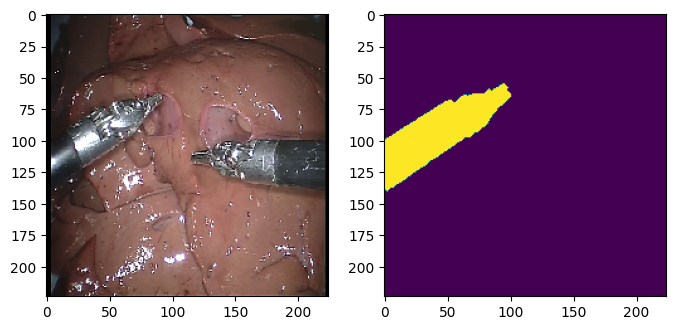

In [ ]:
X,y = train_generator.__getitem__(2)
t = 12

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

In [ ]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

4

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(224 , 224 , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0]

In [ ]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
model.compile(optimizer='adam', loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = []
model.metrics_names

[]

In [ ]:

results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

<ipython-input-41-d70f7477409c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)
<ipython-input-33-a12701893d80>:57: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-33-a12701893d80>:58: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/40
26/26 [==============================] - 143s 2s/step - loss: 0.1228 - dice_coef: 0.5737 - accuracy: 0.9541 - val_loss: 0.9143 - val_dice_coef: 0.1422 - val_accuracy: 0.0765
Epoch 2/40
26/26 [==============================] - 64s 2s/step - loss: 0.0404 - dice_coef: 0.7805 - accuracy: 0.9934 - val_loss: 0.5803 - val_dice_coef: 0.2072 - val_accuracy: 0.4661
Epoch 3/40
26/26 [==============================] - 64s 2s/step - loss: 0.0273 - dice_coef: 0.8405 - accuracy: 0.9941 - val_loss: 0.0761 - val_dice_coef: 0.6663 - val_accuracy: 0.9590
Epoch 4/40
26/26 [==============================] - 63s 2s/step - loss: 0.0201 - dice_coef: 0.8781 - accuracy: 0.9948 - val_loss: 0.0361 - val_dice_coef: 0.8043 - val_accuracy: 0.9840
Epoch 5/40
26/26 [==============================] - 69s 3s/step - loss: 0.0157 - dice_coef: 0.9023 - accuracy: 0.9952 - val_loss: 0.0245 - val_dice_coef: 0.8549 - val_accuracy: 0.9888
Epoch 6/40
26/26 [==============================] - 64s 2s/step - loss: 0.0131 

In [ ]:
loss = results.history["loss"]
# val_loss = results.history["val_loss"]

dice_coef = results.history["dice_coef"]
# val_dice_coef = results.history["val_dice_coef"]

acc = results.history["accuracy"]
# val_acc = results.history["val_accuracy"]

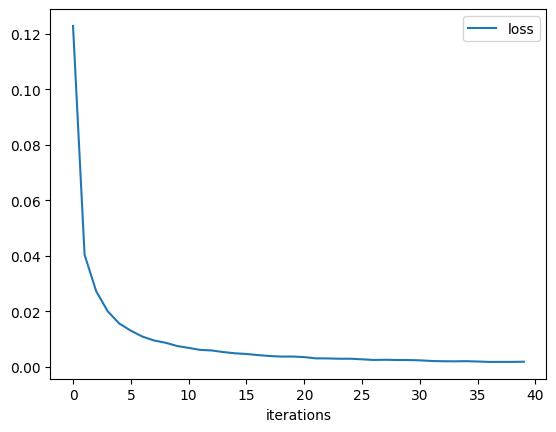

In [ ]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

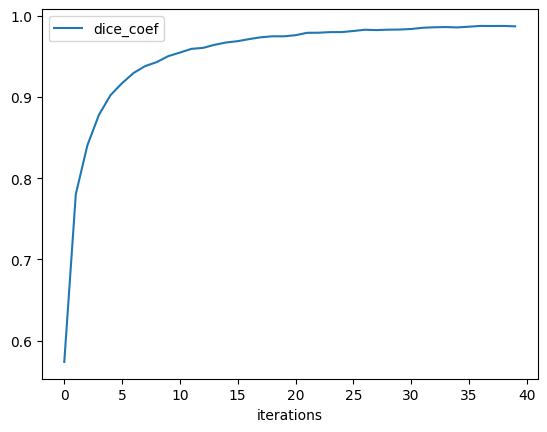

In [ ]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

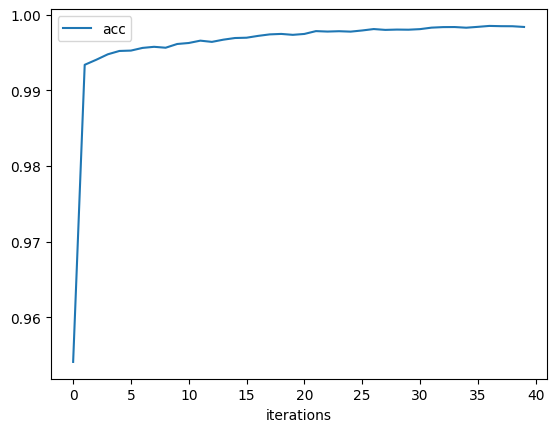

In [ ]:
plt.plot(acc,label = "acc")
plt.xlabel("iterations")
plt.legend()

In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    mask = (mask[0] > 0.5)*1
#     print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask

(576, 720, 3)

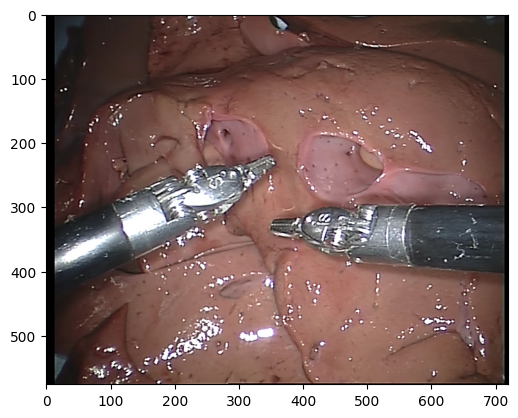

In [ ]:
image = "/content/drive/MyDrive/train_frame/Dataset1/Video/0.png"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 4s 4s/step
(576, 720, 3) (224, 224, 3)


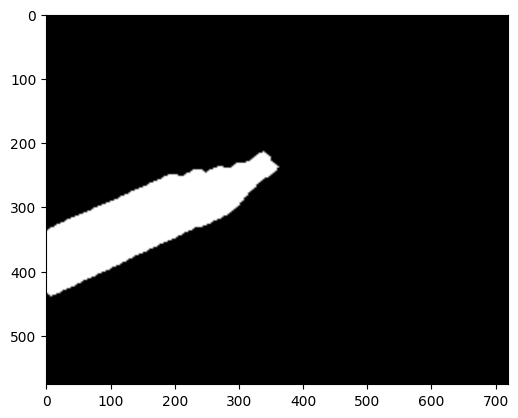

In [ ]:
mask = make_prediction(model,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
plt.imshow(mask2)

In [ ]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]


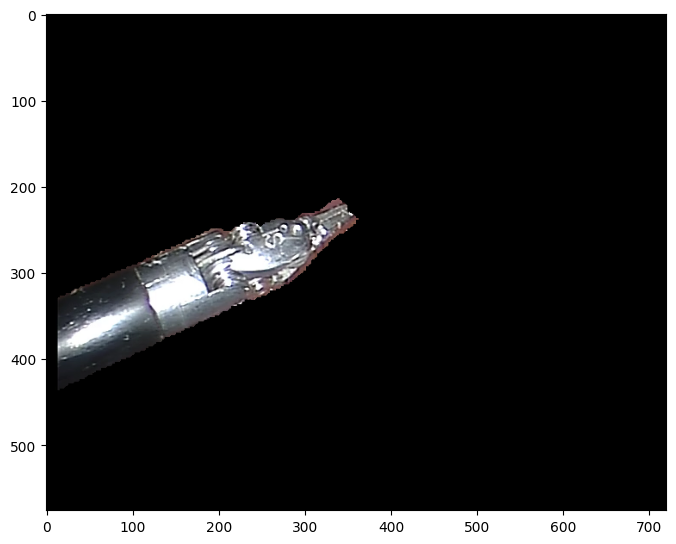

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


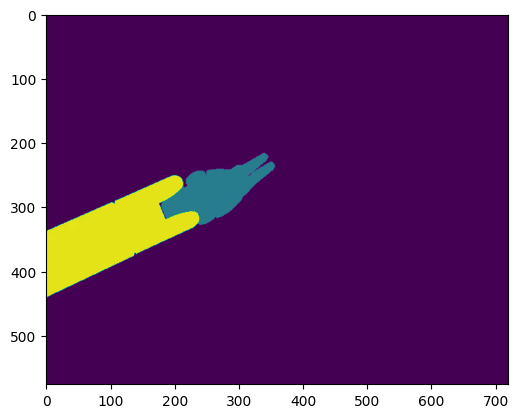

In [ ]:
# prompt: iou with mask and prediction
path= "/content/drive/MyDrive/train_frame/Dataset1/Left_Instrument_Segmentation/0.png"

test = img_to_array(load_img(path,(224,224,3)))
plt.imshow(test)




In [ ]:
print(segment.shape)
import numpy as np
iou = np.sum(np.logical_and(test,segment)) / np.sum(np.logical_or(test,segment))
print(iou)

(576, 720, 3)
0.9007673004037879


In [ ]:
model.save('/content/drive/MyDrive/train_frame/model.h5')